# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\hp\Desktop\AppliedAI\ipython notes\database.sqlite\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
import datetime
final['Time']=pd.to_datetime(final['Time'], unit='s')
final=final.sort_values(by='Time')

In [11]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [12]:
final.dtypes

Id                                 int64
ProductId                         object
UserId                            object
ProfileName                       object
HelpfulnessNumerator               int64
HelpfulnessDenominator             int64
Score                              int64
Time                      datetime64[ns]
Summary                           object
Text                              object
dtype: object

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

(87773, 10)
1    73592
0    14181
Name: Score, dtype: int64


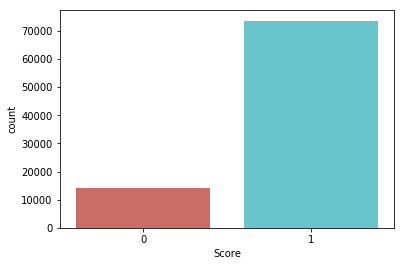

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())

import seaborn as sns
sns.countplot(x='Score',data=final,palette='hls')
plt.show()

**Observations:**
   * We can see the dataset has imbalanced behaviour.

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be ha

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be happily prov

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My dogs just love this food. The service is always fast and reliable.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My dogs just love this food The service is always fast and reliable 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:38<00:00, 2270.25it/s]


In [26]:
preprocessed_reviews[1500]

'dogs love food service always fast reliable'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
con=sqlite3.connect(r'C:\Users\hp\Desktop\AppliedAI\ipython notes\database.sqlite\database.sqlite')
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)
df=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score !=3 LIMIT 100000''',con)
score_column=df['Score']
changed_score=score_column.map(partition)
df['Score']=changed_score
#df.head()
dis=pd.read_sql_query('SELECT ProductId,UserID,ProfileName,Score,Time,Summary,COUNT(*) FROM Reviews GROUP BY UserId HAVING COUNT(*)>1',con)
#dis.head()
sorted_df=df.sort_values('ProductId', axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
f=sorted_df.drop_duplicates(subset={'UserId','ProfileName','Time','Summary'},keep='first', inplace=False)
f=f[f.HelpfulnessNumerator<=f.HelpfulnessDenominator]


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
'''
def extract_data_from_report3(filename):
    #html_report_part1 = open(f['Summary'],'r')
    soup = BeautifulSoup(f['Summary'].all(), "html.parser")
    th = soup.find_all('th')
    td = soup.find_all('td')

    headers = [header.get_text(strip=True) for header in soup.find_all("th")]
    rows = [dict(zip(headers, [td.get_text(strip=True) for td in row.find_all("td")]))
        for row in soup.find_all("tr")[1:-1]]
    print(rows)
    return rows'''

from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_summaries=list()
for i in tqdm(f['Summary'].values):
    i=re.sub(r"http\s+","",i)
    i=BeautifulSoup(i,'html.parser').get_text()
    i=decontracted(i)
    i=re.sub('\s*\d\s*','',i)
    i=re.sub('[^A-Za-z0-9]+','',i)
    i=''.join(e.lower() for e in i.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(i.strip())

 37%|███████████████████████████▎                                              | 32336/87696 [00:03<00:06, 9000.21it/s]C:\Users\hp\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▌                      | 61063/87696 [00:06<00:02, 9191.26it/s]C:\Users\hp\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 74%|██████████████████████████████████████████████████████▊                   | 64886/87696 [00:07<00:02, 8947.61it/s]C:\Users\hp\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Bea

In [28]:
len(preprocessed_summaries)

87696

# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [32]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews[:30000]:
    list_of_sentance.append(sentance.split())

print(len(list_of_sentance))

30000


In [33]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

C:\Users\hp\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('fantastic', 0.8029453754425049), ('terrific', 0.7977877855300903), ('awesome', 0.7928118109703064), ('good', 0.7762162685394287), ('wonderful', 0.7686684131622314), ('excellent', 0.7649029493331909), ('perfect', 0.760311484336853), ('amazing', 0.717766523361206), ('nice', 0.6859786510467529), ('decent', 0.6648209095001221)]
[('best', 0.7947326898574829), ('tastiest', 0.7636843323707581), ('greatest', 0.7369721531867981), ('compares', 0.719733715057373), ('closest', 0.711532711982727), ('richest', 0.7099144458770752), ('smoothest', 0.6798896193504333), ('superior', 0.6795936822891235), ('bear', 0.6697354316711426), ('ive', 0.6660510301589966)]


In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10391
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:53<00:00, 562.41it/s]


30000
50


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews[:30000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [09:06<00:00, 46.40it/s]


30000
50


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [38]:
# Please write all the code with proper documentation

In [147]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

In [148]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer() #initiating the bag of words library using countvectorizer.
#machine is reading all the words as we gave access to only training text data.
count_vect.fit(x_train)

#countvectorizer is transforming the read text data into vectors.
x_trn_bow=count_vect.transform(x_train)
x_tst_bow=count_vect.transform(x_test)

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_bow=stand.fit_transform(x_trn_bow)
x_tst_bow=stand.fit_transform(x_tst_bow)

In [149]:
x_trn_bow.shape,x_tst_bow.shape

((61441, 45800), (26332, 45800))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase th

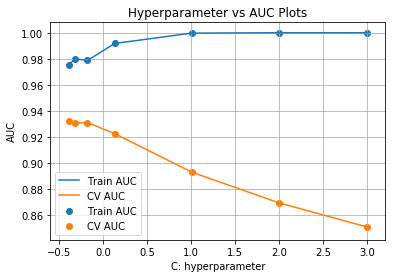

In [42]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
#import math
model=LogisticRegression(penalty='l1',class_weight='balanced')
parameters={'C': uniform.rvs(np.logspace(-3,3,7))}
clf=RandomizedSearchCV(model,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf=clf.fit(x_trn_bow,y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC Plots")
plt.grid()
plt.show()

In [150]:
best_c=clf.best_params_['C']
print(best_c)

0.30821102375681675


In [44]:
def find_best_threshold(Threshold, fpr, tpr):
    t = Threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr):", max(tpr*(1-fpr)), "------> for Threshold:", np.round(t,3))
    return t

def predict_with_best_t(proba, Threshold):
    predictions = []
    for i in proba:
        if i>=Threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

LogisticRegression(C=0.30821102375681675, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.94076858265489


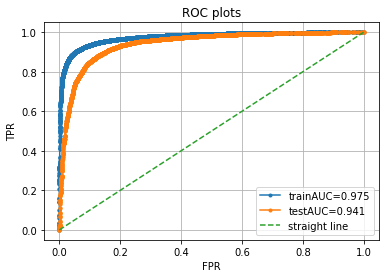

In [151]:
#Now testing with Test data.
model = LogisticRegression(penalty='l1',C=best_c,class_weight='balanced')
model.fit(x_trn_bow, y_train)
y_trn_pred=model.predict(x_trn_bow)
y_tst_pred= model.predict(x_tst_bow)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probs=model.predict_proba(x_trn_bow)[:,1]
x_tst_probs=model.predict_proba(x_tst_bow)[:,1]
print(clf.best_estimator_)
print(clf.score(x_tst_bow, y_test))
# Also we have direct library 'auc' to find the Area Under the ROC Curve. i have plotted in below graph.
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probs)
test_fpr,test_tpr,thresholds=roc_curve(y_test,x_tst_probs)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.8528014674374259 ------> for Threshold: 0.542
confusion matrix using train data:
[[ 8952   668]
 [ 4486 47335]]


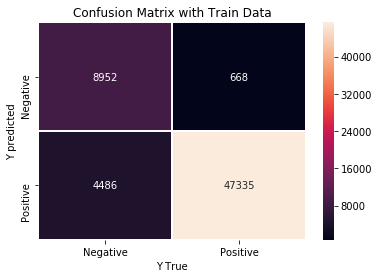

In [46]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

r=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(r, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[ 3899   662]
 [ 2309 19462]]


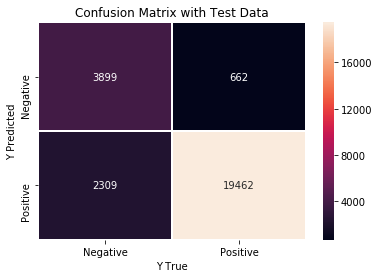

In [47]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
e=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(e, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y True')
plt.ylabel('Y Predicted')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [48]:
# sparcity of LR model with L1 regularization
w = model.coef_
print(np.count_nonzero(w))

2878


In [49]:
#adding noise to the x_train 
x_trn_bow.data+=np.e

In [50]:
model_new = LogisticRegression(penalty='l1',C=best_c,class_weight='balanced')
model_new.fit(x_trn_bow, y_train)
#Sparcity of the LR model features after adding a noise.
w_new=model_new.coef_
print(np.count_nonzero(w_new))

5748


In [51]:
# Adding the small eps value to eliminate the divisible by zero error to W and W’ 
w = w+10**-6 
w_new = w_new+10**-6

percentage_change_vector = (abs( (w-w_new) / (w) ))*100
print('percentage_change_vector:',percentage_change_vector.shape)

percentage_change_vector: (1, 45800)


In [52]:
for i in range(0,105,5):
    print('for {0}th percentile, we got: {1}'.format(i,np.percentile(percentage_change_vector,i)))

for 0th percentile, we got: 0.0
for 5th percentile, we got: 0.0
for 10th percentile, we got: 0.0
for 15th percentile, we got: 0.0
for 20th percentile, we got: 0.0
for 25th percentile, we got: 0.0
for 30th percentile, we got: 0.0
for 35th percentile, we got: 0.0
for 40th percentile, we got: 0.0
for 45th percentile, we got: 0.0
for 50th percentile, we got: 0.0
for 55th percentile, we got: 0.0
for 60th percentile, we got: 0.0
for 65th percentile, we got: 0.0
for 70th percentile, we got: 0.0
for 75th percentile, we got: 0.0
for 80th percentile, we got: 0.0
for 85th percentile, we got: 0.0
for 90th percentile, we got: 56.895475051727324
for 95th percentile, we got: 4984827.950879819
for 100th percentile, we got: 244829815.32695276


In [53]:
for i in range(90,100,1):
    print('for {0}th percentile, we got: {1}'.format(i,np.percentile(percentage_change_vector,i)))

for 90th percentile, we got: 56.895475051727324
for 91th percentile, we got: 66.07880197650535
for 92th percentile, we got: 83.73959041058642
for 93th percentile, we got: 259.0416437628043
for 94th percentile, we got: 2029565.2880862113
for 95th percentile, we got: 4984827.950879819
for 96th percentile, we got: 8712422.17780028
for 97th percentile, we got: 14226200.87391196
for 98th percentile, we got: 22223928.430969875
for 99th percentile, we got: 36442629.92223711


In [145]:
for i in np.arange(93.0,94.1,0.1):
    print('for {0}th percentile, we got: {1}'.format(i,np.percentile(percentage_change_vector,i)))

for 93.0th percentile, we got: 259.0416437628043
for 93.1th percentile, we got: 344.54538343031635
for 93.19999999999999th percentile, we got: 597.2654592290364
for 93.29999999999998th percentile, we got: 1341.3149211679724
for 93.39999999999998th percentile, we got: 85978.84597242669
for 93.49999999999997th percentile, we got: 396882.81716309785
for 93.59999999999997th percentile, we got: 677696.4356075795
for 93.69999999999996th percentile, we got: 944077.8753906355
for 93.79999999999995th percentile, we got: 1256121.7519618426
for 93.89999999999995th percentile, we got: 1618569.9957844533
for 93.99999999999994th percentile, we got: 2029565.288086139


**Obcervations:**
 * we can see from above that at **93.29th percentile** there is an sudden increase of vector change ie. the **Threshold** is set at **1341.50** 
 

In [152]:
# the features greater than the threshold is :
weightsl1=model.coef_[0]
# the below argsort gives the sorted indices as output.
prob_sorted_indices = np.array(weightsl1[1341:]).argsort()
#now getting the features_names as with sorted indices.
features=np.take(count_vect.get_feature_names(), prob_sorted_indices)
print('number of features greater than threshold are: {} ,out of 45800 features'.format(len(features)))
pd.DataFrame(features,columns=['features']).head(10)

number of features greater than threshold are: 44459 ,out of 45800 features


,features
0,bonheur
1,vixen
2,breaks
3,hat
4,dart
5,recive
6,dasani
7,curly
8,guayusa
9,bonfire


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [56]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer() #initiating the bag of words library using countvectorizer.
#machine is reading all the words as we gave access to only training text data.
count_vect.fit(x_train)

#countvectorizer is transforming the read text data into vectors.
x_trn_bow=count_vect.transform(x_train)
x_tst_bow=count_vect.transform(x_test)

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_bow=stand.fit_transform(x_trn_bow)
x_tst_bow=stand.fit_transform(x_tst_bow)

In [58]:
x_trn_bow.shape,x_tst_bow.shape

((61441, 45800), (26332, 45800))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase th

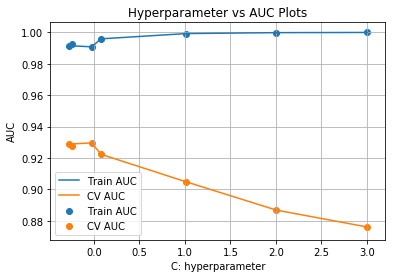

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
#import math
model1=LogisticRegression(penalty='l2',class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clf1=RandomizedSearchCV(model1,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf1=clf1.fit(x_trn_bow,y_train)

train_auc= clf1.cv_results_['mean_train_score']
train_auc_std= clf1.cv_results_['std_train_score']
cv_auc = clf1.cv_results_['mean_test_score'] 
cv_auc_std= clf1.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC Plots")
plt.grid()
plt.show()

In [60]:
best_c=clf1.best_params_['C']
print(best_c)

0.4082614784119013


LogisticRegression(C=0.4082614784119013, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.9368679267564064


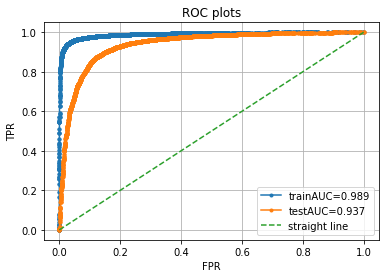

In [61]:
#Now testing with Test data.
model1 = LogisticRegression(penalty='l2',C=best_c,class_weight='balanced')
model1.fit(x_trn_bow, y_train)
y_trn_pred=model1.predict(x_trn_bow)
y_tst_pred= model1.predict(x_tst_bow)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probs=model1.predict_proba(x_trn_bow)[:,1]
x_tst_probs=model1.predict_proba(x_tst_bow)[:,1]
print(clf1.best_estimator_)
print(clf1.score(x_tst_bow, y_test))
# Also we have direct library 'auc' to find the Area Under the ROC Curve. i have plotted in below graph.
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probs)
test_fpr,test_tpr,thresholds=roc_curve(y_test,x_tst_probs)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.9156314148884729 ------> for Threshold: 0.485
confusion matrix using train data:
[[ 9330   290]
 [ 2987 48834]]


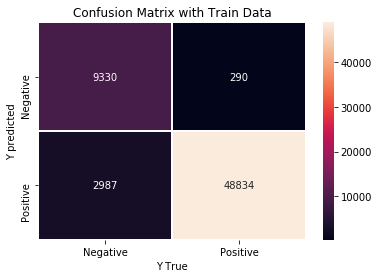

In [62]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

r=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(r, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[ 3773   788]
 [ 1917 19854]]


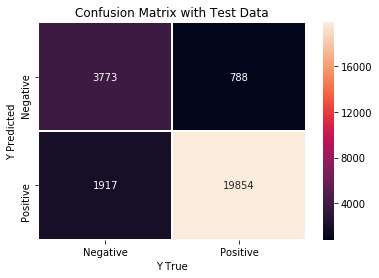

In [63]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
e=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(e, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y True')
plt.ylabel('Y Predicted')
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [64]:
# Please write all the code with proper documentation

In [65]:
# sparcity of LR model with L2 regularization
w1 = model1.coef_
print(np.count_nonzero(w1))

45800


In [66]:
#adding noise to the x_train 
x_trn_bow.data+=np.e

In [67]:
model_new1 = LogisticRegression(penalty='l1',C=best_c,class_weight='balanced')
model_new1.fit(x_trn_bow, y_train)
#Sparcity of the LR model features after adding a noise.
w_new1=model_new1.coef_
print(np.count_nonzero(w_new1))

6417


In [68]:
# Adding the small eps value to eliminate the divisible by zero error to W and W’ 
w1 = w1+10**-6 
w_new1 = w_new1+10**-6

percentage_change_vector1 = (abs( (w1-w_new1) / (w1) ))*100
print('percentage_change_vector:',percentage_change_vector1.shape)

percentage_change_vector: (1, 45800)


In [69]:
for i in range(0,105,5):
    print('for {0}th percentile, we got: {1}'.format(i,np.percentile(percentage_change_vector1,i)))

for 0th percentile, we got: 0.015207713618276645
for 5th percentile, we got: 34.10777475131731
for 10th percentile, we got: 58.38345566302802
for 15th percentile, we got: 78.36071060350325
for 20th percentile, we got: 96.45296541952519
for 25th percentile, we got: 99.54513244436191
for 30th percentile, we got: 99.89200592243019
for 35th percentile, we got: 99.96546311897347
for 40th percentile, we got: 99.9846674958805
for 45th percentile, we got: 99.9923470361803
for 50th percentile, we got: 99.99559436907617
for 55th percentile, we got: 99.99726221725244
for 60th percentile, we got: 99.99820069520311
for 65th percentile, we got: 99.99880357028248
for 70th percentile, we got: 99.99920813780615
for 75th percentile, we got: 99.99950463049672
for 80th percentile, we got: 100.0003765016486
for 85th percentile, we got: 100.00088604229886
for 90th percentile, we got: 100.00240871964169
for 95th percentile, we got: 100.02743307856842
for 100th percentile, we got: 1357232.6937025895


In [70]:
for i in range(90,101,1):
    print('for {0}th percentile, we got: {1}'.format(i,np.percentile(percentage_change_vector1,i)))

for 90th percentile, we got: 100.00240871964169
for 91th percentile, we got: 100.00316871757141
for 92th percentile, we got: 100.00449021312878
for 93th percentile, we got: 100.00750477180611
for 94th percentile, we got: 100.01177993706656
for 95th percentile, we got: 100.02743307856842
for 96th percentile, we got: 100.10582936091613
for 97th percentile, we got: 101.82871663517243
for 98th percentile, we got: 152.73792134324796
for 99th percentile, we got: 315.0399980292838
for 100th percentile, we got: 1357232.6937025895


In [71]:
for i in np.arange(99.0,100.1,0.1):
    print('for {0}th percentile, we got: {1}'.format(i,np.percentile(percentage_change_vector1,i)))

for 99.0th percentile, we got: 315.0399980292838
for 99.1th percentile, we got: 355.00444594461123
for 99.19999999999999th percentile, we got: 445.6868261047522
for 99.29999999999998th percentile, we got: 548.1165629382879
for 99.39999999999998th percentile, we got: 565.3532582250601
for 99.49999999999997th percentile, we got: 651.8241066470251
for 99.59999999999997th percentile, we got: 814.2907710356003
for 99.69999999999996th percentile, we got: 875.5048054269421
for 99.79999999999995th percentile, we got: 1236.5271206743523
for 99.89999999999995th percentile, we got: 2976.004200803499
for 99.99999999999994th percentile, we got: 1357232.6937025895


**Observations:**
 * we can see from above that at **99.89th percentile** there is an sudden increase of vector change ie. the **Threshold** is set at **2976.041** 

In [72]:
# the features greater than the threshold is :
weightsl2=model1.coef_[0]
# the below argsort gives the sorted indices as output.
prob_sorted_indices = np.array(weightsl2[2976:]).argsort()
#now getting the features_names as with sorted indices.
featuresl2=np.take(count_vect.get_feature_names(), prob_sorted_indices)
print('number of features greater than threshold are: {} ,out of 45800 features'.format(len(featuresl2)))
pd.DataFrame(featuresl2,columns=['features']).head(10)

number of features greater than threshold are: 45588 ,out of 45800 features


,features
0,withnatural
1,differently
2,revisited
3,tearzap
4,differet
5,attorneys
6,caffiene
7,hive
8,determinedly
9,thesame


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [73]:
logweights=model1.coef_[0]

neg_weights = list(filter(lambda x: (x < 0), logweights)) 
   
pos_weights = list(filter(lambda x: (x >= 0), logweights)) 
  
print("number of Positive feature weights in the list: ", len(pos_weights)) 
print("number of Negative feature weights in the list: ", len(neg_weights))

number of Positive feature weights in the list:  32096
number of Negative feature weights in the list:  13704


In [74]:
# the below argsort gives the sorted indices as output.
positive_prob_sorted_indices = np.array(pos_weights).argsort()
#now getting the features_names as with those top 10 sorted indices.
top10_pos_features=np.take(count_vect.get_feature_names(), positive_prob_sorted_indices[-10:])
pd.DataFrame(top10_pos_features,columns=['Top10_positive_features'])

,Top10_positive_features
0,interweb
1,capture
2,pursuing
3,molded
4,acidophilus
5,cupsstock
6,erh
7,clayton
8,jalepemo
9,assome


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [75]:
# the below argsort gives the sorted feature_log _prob indices as output.
negative_prob_sorted_indices = np.array(neg_weights).argsort()
#now getting the features_names as with those top 10 sorted indices.
top10_neg_features=np.take(count_vect.get_feature_names(), negative_prob_sorted_indices[-10:])
pd.DataFrame(top10_neg_features,columns=['Top10_negative_features'])

,Top10_negative_features
0,deffently
1,acorn
2,couscousthe
3,aoverall
4,cocoanut
5,accompanies
6,cursing
7,begged
8,blades
9,everythong


## Feature Engineering

In [76]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

In [77]:
review_count=list()
for i in preprocessed_reviews:
    review_count.append(len(i.split()))

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer() #initiating the bag of words library using countvectorizer.
#machine is reading all the words as we gave access to only training text data.
vect.fit(x_train)

#countvectorizer is transforming the read text data into vectors.
x_trn_bows=vect.transform(x_train)
x_tst_bows=vect.transform(x_test[:26255])
xsumm_trn_bows=vect.transform(preprocessed_summaries[:61441])
xsumm_tst_bows=vect.transform(preprocessed_summaries[61441:])

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_bows=stand.fit_transform(x_trn_bows)
x_tst_bows=stand.fit_transform(x_tst_bows)
xsumm_trn_bows=stand.fit_transform(xsumm_trn_bows)
xsumm_tst_bows=stand.fit_transform(xsumm_tst_bows)

In [79]:
x_trn_bows.shape,x_tst_bows.shape,xsumm_tst_bows.shape,xsumm_trn_bows.shape

((61441, 45800), (26255, 45800), (26255, 45800), (61441, 45800))

In [80]:
from scipy.sparse import csr_matrix,hstack
s=csr_matrix((review_count[:61441]),dtype=np.int64).T
d=csr_matrix((review_count[61441:]),dtype=np.int64).T
d=d[:26255]

x_tr=hstack([x_trn_bows,s,xsumm_trn_bows])
x_ts=hstack([x_tst_bows,d,xsumm_tst_bows])

In [81]:
x_tr.shape,x_ts.shape

((61441, 91601), (26255, 91601))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase th

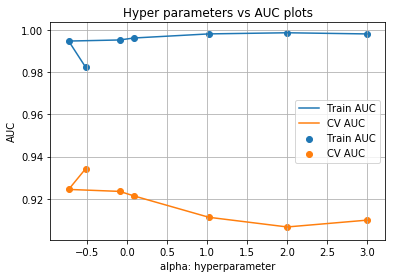

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
models=LogisticRegression(class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clfs=RandomizedSearchCV(models,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clfs=clfs.fit(x_tr,y_train)

train_auc= clfs.cv_results_['mean_train_score']
train_auc_std= clfs.cv_results_['std_train_score']
cv_auc = clfs.cv_results_['mean_test_score'] 
cv_auc_std= clfs.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameters vs AUC plots")
plt.grid()
plt.show()

In [83]:
best=clfs.best_params_['C']
print(best)

0.11609110905825959


LogisticRegression(C=0.11609110905825959, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.9412485551766823


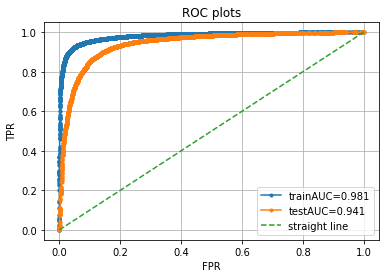

In [84]:
#Now testing with Test data.
models = LogisticRegression(C=best,class_weight='balanced')
models.fit(x_tr, y_train)
y_trn_predS=models.predict(x_tr)
y_tst_predS= models.predict(x_ts)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probs=models.predict_proba(x_tr)[:,1]
x_tst_probs=models.predict_proba(x_ts)[:,1]
print(clfs.best_estimator_)
print(clfs.score(x_ts, y_test[:26255]))
# Also we have direct library 'auc' to find the Area Under the ROC Curve. i have plotted in below graph.
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probs)
test_fpr,test_tpr,thresholds=roc_curve(y_test[:26255],x_tst_probs)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.8785550460141842 ------> for Threshold: 0.482
confusion matrix using train data:
[[ 9133   487]
 [ 3916 47905]]


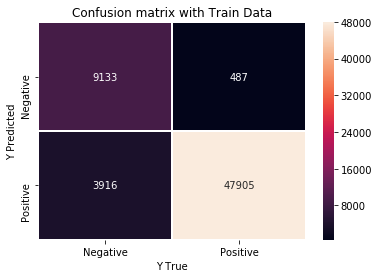

In [85]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_predS, best_t)))

a=confusion_matrix(y_train,predict_with_best_t(y_trn_predS, best_t))
import seaborn as sns
sns.heatmap(a, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y Predicted')
plt.show()

confusion matrix using test data:
[[ 3862   688]
 [ 2074 19631]]


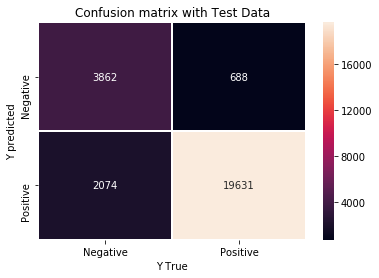

In [86]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test[:26255],predict_with_best_t(y_tst_predS, best_t)))
b=confusion_matrix(y_test[:26255],predict_with_best_t(y_tst_predS, best_t))
import seaborn as sns
sns.heatmap(b, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Test Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

In [87]:
logweights=models.coef_[0]

neg_weights = list(filter(lambda x: (x < 0), logweights)) 
   
pos_weights = list(filter(lambda x: (x >= 0), logweights)) 
  
print("number of Positive feature weights in the list: ", len(pos_weights)) 
print("number of Negative feature weights in the list: ", len(neg_weights))

number of Positive feature weights in the list:  78617
number of Negative feature weights in the list:  12984


In [88]:
# the below argsort gives the sorted feature_log _prob indices as output.
Positive_prob_sorted_indices = np.array(pos_weights).argsort()
#now getting the features_names as with those top 10 sorted indices.
Top10_pos_features=np.take(vect.get_feature_names(), Positive_prob_sorted_indices[-10:])
pd.DataFrame(Top10_pos_features,columns=['Top10_positive_features'])

,Top10_positive_features
0,gocery
1,albersons
2,rangular
3,aqnd
4,redefines
5,exceeds
6,athletic
7,jazz
8,dares
9,coagulates


In [89]:
# the below argsort gives the sorted feature_log _prob indices as output.
Negative_prob_sorted_indices = np.array(neg_weights).argsort()
#now getting the features_names as with those top 10 sorted indices.
Top10_neg_features=np.take(vect.get_feature_names(), Negative_prob_sorted_indices[-10:])
pd.DataFrame(Top10_neg_features,columns=['Top10_negative_features'])

,Top10_negative_features
0,dietingredientscertified
1,clearish
2,compacting
3,berriness
4,ediable
5,apbt
6,bullmastiff
7,crumbly
8,analytical
9,border


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [90]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect= TfidfVectorizer(ngram_range=(1,2),min_df=10) #initiating Tfidf
#machine is reading or learning all the text reviews from training data
tf_idf_vect.fit(x_train)

#Now transforming all the words learnt into vectors.
x_trn_tfidf=tf_idf_vect.transform(x_train)
x_tst_tfidf= tf_idf_vect.transform(x_test)

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_tfidf=stand.fit_transform(x_trn_tfidf)
x_tst_tfidf=stand.fit_transform(x_tst_tfidf)

In [92]:
x_trn_tfidf.shape,x_tst_tfidf.shape

((61441, 36171), (26332, 36171))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


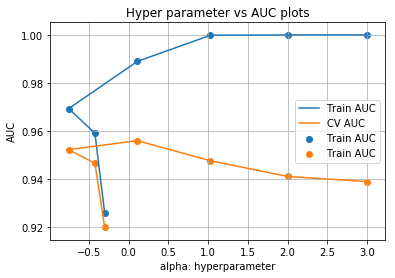

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
model2=LogisticRegression(penalty='l1',class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clf2=RandomizedSearchCV(model2,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf2=clf2.fit(x_trn_tfidf,y_train)

train_auc= clf2.cv_results_['mean_train_score']
train_auc_std= clf2.cv_results_['std_train_score']
cv_auc = clf2.cv_results_['mean_test_score'] 
cv_auc_std= clf2.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='Train AUC')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter vs AUC plots")
plt.grid()
plt.show()

In [94]:
best_alpha_tfidf=clf2.best_params_['C']
print(best_alpha_tfidf)

1.8932570844366574


LogisticRegression(C=1.8932570844366574, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.9633132972863143


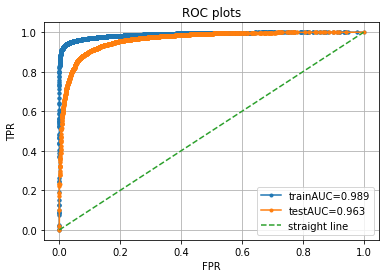

In [95]:
#Now testing with Test data.
model2=LogisticRegression(penalty='l1',C=best_alpha_tfidf,class_weight='balanced')
model2.fit(x_trn_tfidf, y_train)
y_trn_predss=model2.predict(x_trn_tfidf)
y_tst_predss= model2.predict(x_tst_tfidf)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probss=model2.predict_proba(x_trn_tfidf)[:,1]
x_tst_probss=model2.predict_proba(x_tst_tfidf)[:,1]
print(clf2.best_estimator_)
print(clf2.score(x_tst_tfidf, y_test))
# Also we have direct library 'auc' to find the Area Under the ROC Curve. i have plotted in below graph.
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probss)
test_fpr,test_tpr,thresholds=roc_curve(y_test,x_tst_probss)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.9168298469932942 ------> for Threshold: 0.513
confusion matrix using train data:
[[ 9368   252]
 [ 3056 48765]]


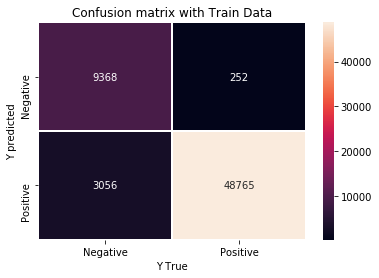

In [96]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_predss, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_predss, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[ 3975   586]
 [ 1700 20071]]


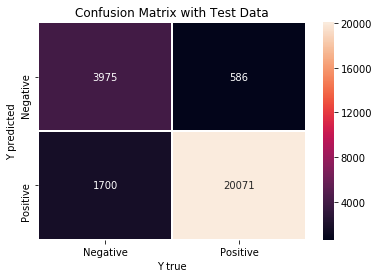

In [97]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_predss, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_predss, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [98]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect= TfidfVectorizer(ngram_range=(1,2),min_df=10) #initiating Tfidf
#machine is reading or learning all the text reviews from training data
tf_idf_vect.fit(x_train)

#Now transforming all the words learnt into vectors.
x_trn_tfidf=tf_idf_vect.transform(x_train)
x_tst_tfidf= tf_idf_vect.transform(x_test)

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_tfidf=stand.fit_transform(x_trn_tfidf)
x_tst_tfidf=stand.fit_transform(x_tst_tfidf)

In [100]:
x_trn_tfidf.shape,x_tst_tfidf.shape

((61441, 36171), (26332, 36171))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


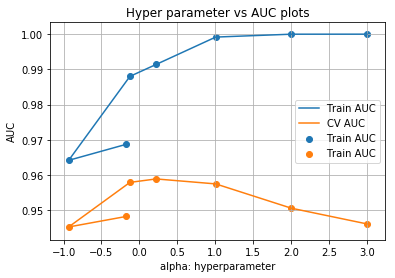

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
model3=LogisticRegression(penalty='l2',class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clf3=RandomizedSearchCV(model3,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf3=clf3.fit(x_trn_tfidf,y_train)

train_auc= clf3.cv_results_['mean_train_score']
train_auc_std= clf3.cv_results_['std_train_score']
cv_auc = clf3.cv_results_['mean_test_score'] 
cv_auc_std= clf3.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='Train AUC')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter vs AUC plots")
plt.grid()
plt.show()

In [102]:
best_alpha_tfid=clf3.best_params_['C']
print(best_alpha_tfid)

1.5327504783917494


LogisticRegression(C=1.5327504783917494, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.965120844746885


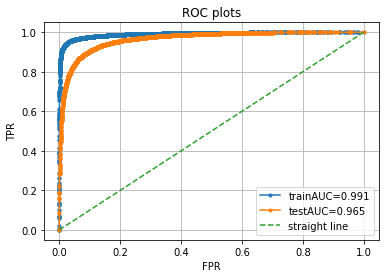

In [103]:
#Now testing with Test data.
model3=LogisticRegression(penalty='l2',C=best_alpha_tfid,class_weight='balanced')
model3.fit(x_trn_tfidf, y_train)
y_trn_predss=model3.predict(x_trn_tfidf)
y_tst_predss= model3.predict(x_tst_tfidf)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probss=model3.predict_proba(x_trn_tfidf)[:,1]
x_tst_probss=model3.predict_proba(x_tst_tfidf)[:,1]
print(clf3.best_estimator_)
print(clf3.score(x_tst_tfidf, y_test))
# Also we have direct library 'auc' to find the Area Under the ROC Curve. i have plotted in below graph.
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probss)
test_fpr,test_tpr,thresholds=roc_curve(y_test,x_tst_probss)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.9216119208689788 ------> for Threshold: 0.491
confusion matrix using train data:
[[ 9377   243]
 [ 2870 48951]]


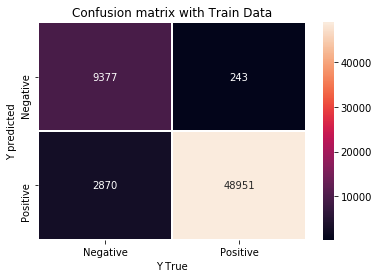

In [104]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_predss, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_predss, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[ 3977   584]
 [ 1663 20108]]


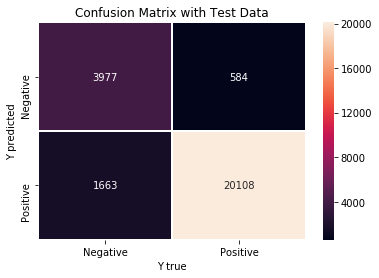

In [105]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_predss, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_predss, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [106]:
logweights=model2.coef_[0]

neg_weights = list(filter(lambda x: (x < 0), logweights)) 
   
pos_weights = list(filter(lambda x: (x >= 0), logweights)) 
  
print("number of Positive feature weights in the list: ", len(pos_weights)) 
print("number of Negative feature weights in the list: ", len(neg_weights))

number of Positive feature weights in the list:  33802
number of Negative feature weights in the list:  2369


In [107]:
# the below argsort gives the sorted feature_log _prob indices as output.
positive_prob_sorted_indicess = np.array(pos_weights).argsort()
#now getting the features_names as with those top 10 sorted indices.
TOP10_pos_features=np.take(tf_idf_vect.get_feature_names(), positive_prob_sorted_indicess[-10:])
pd.DataFrame(TOP10_pos_features,columns=['Top10_positive_features'])

,Top10_positive_features
0,product son
1,great soup
2,like great
3,gallon size
4,beats
5,oh gosh
6,flavor salt
7,currently
8,glass bottles
9,mom made


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [108]:
# the below argsort gives the sorted feature_log _prob indices as output.
negative_prob_sorted_indicess = np.array(neg_weights).argsort()
#now getting the features_names as with those top 10 sorted indices.
TOP10_neg_features=np.take(tf_idf_vect.get_feature_names(), negative_prob_sorted_indicess[-10:])
pd.DataFrame(TOP10_neg_features,columns=['Top10_negative_features'])

,Top10_negative_features
0,bags oz
1,bar newman
2,bags use
3,bagel
4,ago since
5,alternative potato
6,aftertaste mouth
7,bad would
8,also used
9,back together


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [109]:
# Please write all the code with proper documentation

In [110]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:21000]
x_test=preprocessed_reviews[21000:30000]
y_train=final['Score'][:21000]
y_test=final['Score'][21000:30000]

In [111]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

print(len(list_of_sentance_train))

21000


In [112]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

# this line of code trains your w2v model on the give list of sentances
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

C:\Users\hp\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [113]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  8707
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


In [114]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(len(sent_vectors_train))
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [01:11<00:00, 292.17it/s]


21000
[ 0.87214371  0.50966536 -0.56096689 -0.23268479 -0.37445586  0.15678693
  0.22633145  0.0723807  -0.22420137 -0.03874057  0.18953751  0.04864116
 -0.20430083 -0.26932041  0.15327608  0.14215419 -0.15762202  0.2648899
 -0.3718496   0.21763662 -0.33998778 -0.19611106 -0.05980166 -0.09598418
  0.12139961 -0.05041226  0.07769329 -0.04258362 -0.21963587 -0.44209929
 -0.1404784   0.43591073  0.49588126 -0.40642971  0.09433509  0.28331782
 -0.11036827  0.13940588  0.35780605 -0.20629206 -0.24517946  0.19883213
  0.18295145 -0.05597966 -0.30663804  0.4681681   0.11755026  0.28789342
  0.01518504 -0.75169325]


### Converting test text

In [115]:
i=0
list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
    
print(len(list_of_sentance_test))

9000


In [116]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(len(sent_vectors_test))
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:33<00:00, 268.96it/s]


9000
[ 0.76300145  0.53149263 -0.41346067 -0.46572414 -0.48572416  0.02303069
  0.01332113 -0.12666811 -0.53484008  0.1055015   0.36124917  0.22728974
 -0.0019966  -0.3412609   0.16975337  0.0524577  -0.20345565  0.491438
 -0.50401684  0.13193394 -0.69958111 -0.3934525  -0.104477   -0.27506459
  0.18754555 -0.21790675  0.21876909  0.00236725 -0.05613275 -0.14957536
  0.18589856  0.68533287  0.30830384 -0.39873157  0.1755022   0.09463281
 -0.10165544 -0.21101295  0.56678325 -0.26807678  0.00089119  0.38406294
  0.12939877 -0.08686367 -0.05673894  0.51779963  0.34275011  0.48674674
 -0.36386526 -0.76829893]


In [117]:
from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
sent_vectors_train=stand.fit_transform(sent_vectors_train)
sent_vectors_test=stand.fit_transform(sent_vectors_test)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


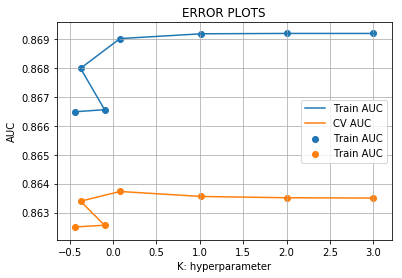

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
model4=LogisticRegression(penalty='l1',class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clf4=RandomizedSearchCV(model4,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf4=clf4.fit(sent_vectors_train,y_train)

train_auc= clf4.cv_results_['mean_train_score']
train_auc_std= clf4.cv_results_['std_train_score']
cv_auc = clf4.cv_results_['mean_test_score'] 
cv_auc_std= clf4.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='Train AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [119]:
bestC=clf4.best_params_['C']
print(bestC)

1.7701153533245753


LogisticRegression(C=1.7701153533245753, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.8690965548816715


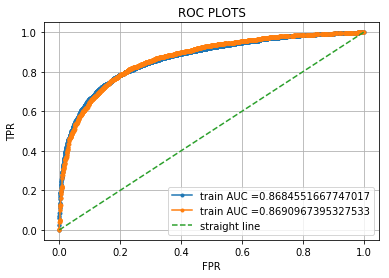

In [120]:
model4=LogisticRegression(penalty='l1',C=bestC,class_weight='balanced')
model4.fit(sent_vectors_train, y_train)
y_trn_pred=model4.predict(sent_vectors_train)
y_tst_pred=model4.predict(sent_vectors_test)

print(clf4.best_estimator_)
print(clf4.score(sent_vectors_test, y_test))
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model4.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model4.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr,marker='.',label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,marker='.',label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.628774435661602 ------> for Threshold: 0.408
confusion matrix using train data:
[[ 2178   473]
 [ 4348 14001]]


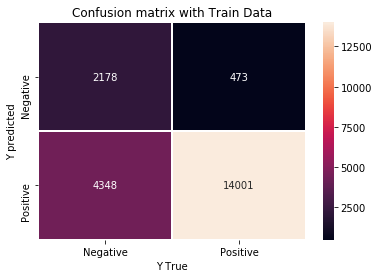

In [121]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[1176  255]
 [1807 5762]]


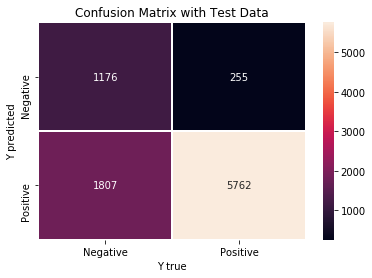

In [122]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


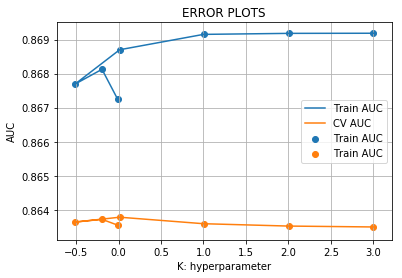

In [123]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
model5=LogisticRegression(penalty='l2',class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clf5=RandomizedSearchCV(model5,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf5=clf5.fit(sent_vectors_train,y_train)

train_auc= clf5.cv_results_['mean_train_score']
train_auc_std= clf5.cv_results_['std_train_score']
cv_auc = clf5.cv_results_['mean_test_score'] 
cv_auc_std= clf5.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='Train AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [124]:
bestC5=clf5.best_params_['C']
print(bestC5)

1.210616893459877


LogisticRegression(C=1.210616893459877, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.8689268605373771


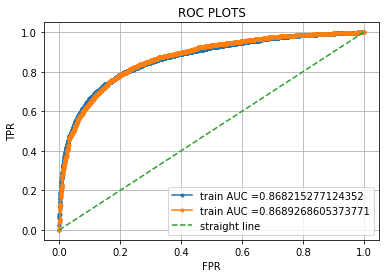

In [125]:
model5=LogisticRegression(penalty='l2',C=bestC5,class_weight='balanced')
model5.fit(sent_vectors_train, y_train)
y_trn_pred=model5.predict(sent_vectors_train)
y_tst_pred=model5.predict(sent_vectors_test)

print(clf5.best_estimator_)
print(clf5.score(sent_vectors_test, y_test))
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model5.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model5.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr,marker='.',label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,marker='.',label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.6283439541054856 ------> for Threshold: 0.407
confusion matrix using train data:
[[ 2174   477]
 [ 4351 13998]]


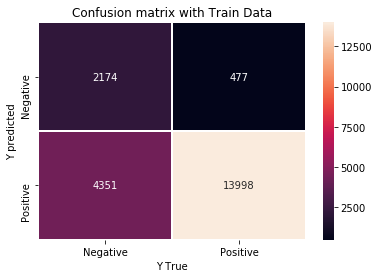

In [126]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[1175  256]
 [1809 5760]]


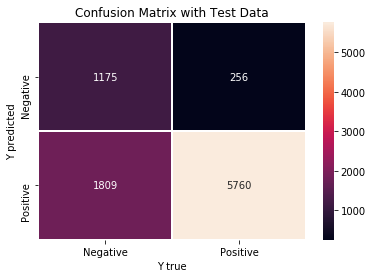

In [127]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [128]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:21000]
x_test=preprocessed_reviews[21000:30000]
y_train=final['Score'][:21000]
y_test=final['Score'][21000:30000]

In [129]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [130]:
# TF-IDF weighted Word2Vec
tfidf_feat_train = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(tfidf_sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 21000/21000 [09:01<00:00, 38.77it/s]


21000
[ 0.70567777  0.48516412 -0.46534936 -0.22045934 -0.3855082   0.19405609
  0.18040897 -0.00106243 -0.20927299 -0.05159421  0.17374408  0.06263685
 -0.19495245 -0.18924364  0.07864855  0.15366842 -0.13428614  0.23993471
 -0.35796852  0.14038531 -0.38306569 -0.18686631 -0.12420754 -0.05265889
  0.03813975 -0.08634308  0.00692378 -0.05244795 -0.11250168 -0.28154413
 -0.08642047  0.45150777  0.44789588 -0.35245944  0.06364385  0.27098174
 -0.16300978  0.06235242  0.31776726 -0.20469612 -0.29188365  0.22628281
  0.16473453 -0.02267219 -0.23419     0.32027153  0.10721405  0.23112349
 -0.02333391 -0.6610152 ]


### Converting test text 

In [131]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_test = model.fit_transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [132]:
# TF-IDF weighted Word2Vec
tfidf_feat_test = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_test:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(tfidf_sent_vectors_test[0])

100%|██████████████████████████████████████████████████████████████████████████████| 9000/9000 [02:45<00:00, 54.52it/s]


9000
[ 7.04154310e-01  5.39064671e-01 -4.07244260e-01 -4.12711521e-01
 -5.00434674e-01  2.41907898e-02  5.31620643e-02 -1.36289919e-01
 -4.92115125e-01  7.46612888e-02  3.45106151e-01  1.94461637e-01
 -7.23624367e-02 -2.77644869e-01  1.04443715e-01  1.11487918e-02
 -2.29734669e-01  4.53663567e-01 -4.91878339e-01  1.08898474e-01
 -6.84591502e-01 -3.64159890e-01 -9.23042134e-02 -2.69095623e-01
  1.32134904e-01 -2.02632974e-01  1.16371727e-01 -3.54683563e-04
 -2.62297634e-02 -1.17477947e-01  1.70746881e-01  7.36496345e-01
  2.93629375e-01 -3.44372761e-01  2.07112562e-01  7.96090457e-02
 -1.40423764e-01 -1.83114495e-01  5.10443571e-01 -2.61077565e-01
 -2.03708567e-02  3.95589384e-01  1.20822630e-01 -6.53844887e-02
 -3.43507107e-02  4.93768648e-01  3.39497947e-01  4.66851697e-01
 -3.55001001e-01 -7.46587134e-01]


In [133]:
from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
tfidf_sent_vectors_train=stand.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_test=stand.fit_transform(tfidf_sent_vectors_test)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


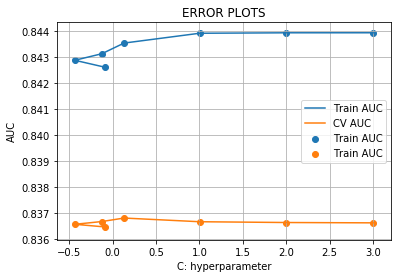

In [134]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
model6=LogisticRegression(penalty='l1',class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clf6=RandomizedSearchCV(model6,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf6=clf6.fit(tfidf_sent_vectors_train,y_train)

train_auc= clf6.cv_results_['mean_train_score']
train_auc_std= clf6.cv_results_['std_train_score']
cv_auc = clf6.cv_results_['mean_test_score'] 
cv_auc_std= clf6.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='Train AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [135]:
bestC6=clf6.best_params_['C']
print(bestC6)

1.067472896125965


LogisticRegression(C=1.067472896125965, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.8461477491171601


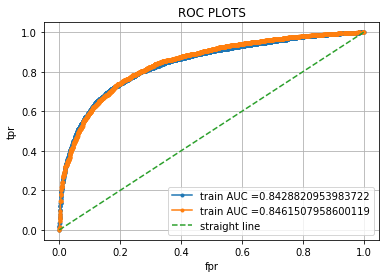

In [136]:
model6=LogisticRegression(penalty='l1',C=bestC6,class_weight='balanced')
model6.fit(tfidf_sent_vectors_train, y_train)
y_trn_pred=model6.predict(tfidf_sent_vectors_train)
y_tst_pred=model6.predict(tfidf_sent_vectors_test)
print(clf6.best_estimator_)
print(clf6.score(tfidf_sent_vectors_test, y_test))

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model6.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model6.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr,marker='.',label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,marker='.',label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.5924108733062561 ------> for Threshold: 0.405
confusion matrix using train data:
[[ 2115   536]
 [ 4748 13601]]


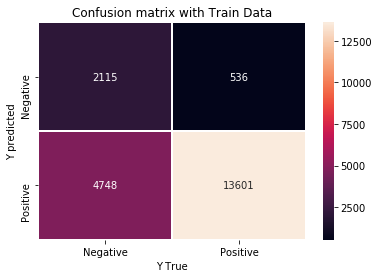

In [137]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[1142  289]
 [1956 5613]]


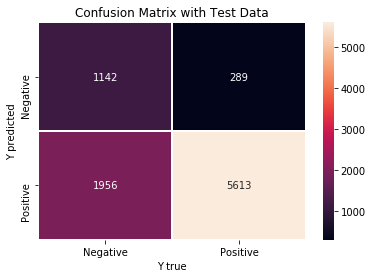

In [138]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


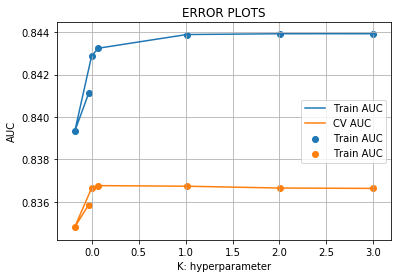

In [139]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
model7=LogisticRegression(penalty='l2',class_weight='balanced')
parameters={'C':uniform.rvs(np.logspace(-3,3,7))}
clf7=RandomizedSearchCV(model7,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf7=clf7.fit(tfidf_sent_vectors_train,y_train)

train_auc= clf7.cv_results_['mean_train_score']
train_auc_std= clf7.cv_results_['std_train_score']
cv_auc = clf7.cv_results_['mean_test_score'] 
cv_auc_std= clf7.cv_results_['std_test_score']

K=np.log10(uniform.rvs(np.logspace(-3,3,7)))
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc,label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc,label='Train AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [140]:
bestC7=clf7.best_params_['C']
print(bestC7)

1.170642322672021


LogisticRegression(C=1.170642322672021, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.8460533000887526


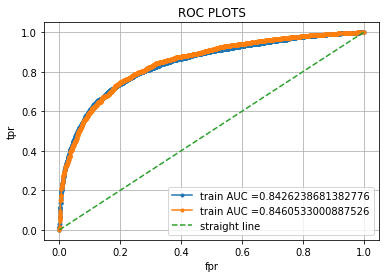

In [141]:
model7=LogisticRegression(penalty='l2',C=bestC7,class_weight='balanced')
model7.fit(tfidf_sent_vectors_train, y_train)
y_trn_pred=model7.predict(tfidf_sent_vectors_train)
y_tst_pred=model7.predict(tfidf_sent_vectors_test)
print(clf7.best_estimator_)
print(clf7.score(tfidf_sent_vectors_test, y_test))

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model7.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model7.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr,marker='.',label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,marker='.',label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.5922355558893239 ------> for Threshold: 0.41
confusion matrix using train data:
[[ 2112   539]
 [ 4753 13596]]


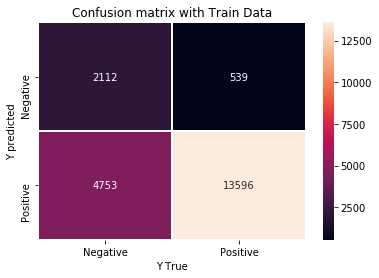

In [142]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[1147  284]
 [1946 5623]]


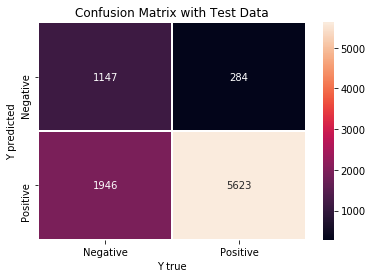

In [143]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

# [6] Conclusions

In [144]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['vectorizer','Regularization','C Hyperparameter','AUC']
x.add_row(['BOW','L1',0.714,0.969])
x.add_row(['BOW','L2',0.189,0.975])
x.add_row(['TFIDF','L1',10.840,0.996])
x.add_row(['TFIDF','L2',10.669,0.995])
x.add_row(['AVG_W2V','L1',10.424,0.870])
x.add_row(['AVG_W2V','L2',10.108,0.870])
x.add_row(['TFIDF_W2V','L1',10.626,0.846])
x.add_row(['TFIDF_W2V','L2',10.090,0.846])

print(x)

+------------+----------------+------------------+-------+
| vectorizer | Regularization | C Hyperparameter |  AUC  |
+------------+----------------+------------------+-------+
|    BOW     |       L1       |      0.714       | 0.969 |
|    BOW     |       L2       |      0.189       | 0.975 |
|   TFIDF    |       L1       |      10.84       | 0.996 |
|   TFIDF    |       L2       |      10.669      | 0.995 |
|  AVG_W2V   |       L1       |      10.424      |  0.87 |
|  AVG_W2V   |       L2       |      10.108      |  0.87 |
| TFIDF_W2V  |       L1       |      10.626      | 0.846 |
| TFIDF_W2V  |       L2       |      10.09       | 0.846 |
+------------+----------------+------------------+-------+
